# <center>Welcome to 21cmFirstCLASS Notebook #2!</center>
### <center>By J. Flitter and S. Libanore</center>
21cmFirstCLASS is an extension of the popular 21cmFAST code that interfaces with CLASS to generate initial conditions consistent with the input cosmological model. These initial conditions can be set during the time of recombination, allowing one to compute the 21cm signal (and its spatial fluctuations) throughout the dark ages, as well as in the proceeding cosmic dawn and reionization epochs, just like in the standard 21cmFAST.

In Notebook #1, you learned how to install 21cmFirstCLASS and its dependencies, how to run the code for basic settings, and how to plot easily the simulation outputs.

#### In this notebook you will learn...
- The new default flags configuration in 21cmFirstCLASS 
- What new features were added to 21cmFirstCLASS (in &Lambda;CDM cosmology)
- How to disable these new features to restore public 21cmFAST

## Installation

To run this notebook, make sure you have CLASS installed in your 21cmFirstCLASS environment. If you need more details on the installation procedure, check Notebook #1.

## General definitions

In [1]:
# Import the packages required for this tutorial

import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt

import py21cmfast as p21c # To run 21cmFirstCLASS (21cmFAST)
from py21cmfast import plotting # For plotting global signals, coeval boxes and lightcone boxes
import py21cmfast.power_spectrum as ps # Calculate power spectrum from the lightcone

from py21cmfast import UserParams, FlagOptions # To show what parameters are used in the simulation
from py21cmfast.inputs import global_params # Useful in this tutorial to plot the growth factors used in the simulation

It is VERY recommended for 21cmFirstCLASS users to have the 'latex' package installed in the same python environment where 21cmFirstCLASS is installed. <br>
If you have latex installed then you may run the next cell, otherwise do not run it as it will raise errors and no plots in this tutorial will be shown!

In [2]:
plt.rcParams.update({"text.usetex": True, "font.family": "Times new roman"}) # Use latex fonts

Define the color palette (this combination is good for colorblindness).

In [3]:
colors =  ['#377eb8', '#ff7f00', '#4daf4a',
           '#f781bf', '#a65628', '#984ea3',
           '#999999', '#e41a1c', '#dede00']

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors) # Set the color palette as default

## New defaults
Some flags in 21cmFirstCLASS have different default values compared to 21cmFAST. You can see the default flags settings by running the following line.

In [4]:
FlagOptions._defaults_

{'USE_HALO_FIELD': False,
 'USE_MINI_HALOS': True,
 'USE_CMB_HEATING': False,
 'USE_Lya_HEATING': False,
 'USE_MASS_DEPENDENT_ZETA': True,
 'SUBCELL_RSD': True,
 'INHOMO_RECO': True,
 'USE_TS_FLUCT': True,
 'M_MIN_in_Mass': False,
 'PHOTON_CONS': False,
 'FIX_VCB_AVG': False}

Specifically, the following flags are set to be True by default.
- USE_TS_FLUCT: whether or not the spin temperature is computed.
- INHOMO_RECO: whether or not the recombination rate is inhomogeneous.
- SUBCELL_RSD: whether or not redshift space distortions are taken into account.
- USE_MASS_DEPENDENT_ZETA: whether or not the star formation rate per halo depends on the halo mass.
- USE_MINI_HALOS: whether or not popIII stars (inside mini-halos) are taken into account in the simulation.

We have also changed the defaults of the following parameters.

In [5]:
print(f'Default value of USE_RELATIVE_VELOCITIES is {UserParams._defaults_["USE_RELATIVE_VELOCITIES"]}')
print(f'Default value of POWER_SPECTRUM is {UserParams._defaults_["POWER_SPECTRUM"]}')

Default value of USE_RELATIVE_VELOCITIES is True
Default value of POWER_SPECTRUM is 5


This means that 21cmFirstCLASS by default:
- takes into account the relative velocity between baryons and cold dark matter (CDM).
- generates initial conditions according to the "CLASS" power spectrum. As we will see, this feature has been improved in 21cmFirstCLASS.

## 1st run: 21cmFirstCLASS
The first simulation we shall perform is similar to the one we had in Notebook #1.

Before running the simulation we need to set its parameters. We begin with setting 'user_params'.

### Important Note!
To speed up the computation we use a rather small box with low resolution. Altough these settings are fine to obtain the correct global history, they are inadequate for studying the fluctuations of the box, or the power spectrum. Make sure to increase BOX_LEN and HII_DIM for reliable simulation of the power spectrum!

In [6]:
# Parameters related with the size of the simulation itself and with the kind of outputs required

user_params = {"BOX_LEN": 100, # size of the simulated box (in comoving Mpc) 
               "HII_DIM": 25, # number of cells along each axis of the coeval box - Note: more cells means longer runtime! 
               "N_THREADS": 6} # whether or not to run CLASS prior to the 21cmFAST simulation.

Now we set the other parameters for the simulation.

In [7]:
# Parameters that set the physical processes the code accounts for

flag_options = {"USE_MINI_HALOS": False, } # if False, popIII stars are not included - Note: if set to True, the runtime increases significantly!

# Cosmological parameters in LCDM

cosmo_params = {"hlittle": 0.6736, # hubble parameter
                "OMb": 0.0493, # baryon density
                "OMm": 0.3153, # matter (CDM+baryon) density
                "A_s": 2.1e-9, # amplitude of the primordial fluctuations
                "POWER_INDEX": 0.9649, # spectral index of the primordial spectrum
                "tau_reio": 0.0544, # optical depth to reionization
                }

# Astrophysical parameters in a standard scenario
# some parameters require to input the log10 value

astro_params = {"F_STAR10": -1.25, # star formation efficiency (atomic cooling galaxies) for pivot mass 1e10 Msun (log10)
                "ALPHA_STAR": 0.5, # slope of the dependency of star formation efficiency on the host halo mass 
                "F_ESC10": -1.35, # escape fraction of Lyman photons into the IGM for pivot mass 1e10 Msun (log10)
                "ALPHA_ESC": -0.3, # slope of the dependency of escape fraction on the host halo mass 
                "L_X": 40.5, # X-ray luminosity (log10)
        
# popIII stars parameters -- use only if USE_MINI_HALOS = True    
                #"F_STAR7_MINI": -2.5, # star formation efficiency (molecular cooling galaxies) for pivot mass 1e7 Msun (log10)
                #"ALPHA_STAR_MINI": 0., # slope of the dependency of star formation efficiency on the host halo mass 
                #"F_ESC7_MINI": -1.35, # escape fraction of Lyman photons into the IGM for molecular cooling galaxies, assumed constant as function of the halo mass (log10)
                # "L_X_MINI": 40.5, # Xray luminosity 
}

global_quantities = ("brightness_temp", # brightness temperature
                     "x_e_box") # free electron fraction

lightcone_quantities = ("brightness_temp",) # brightness temperature

We now run 21cmFirstCLASS with the above settings.

#### Note
Remember: We run the simulation in 21cmFirstCLASS with the build-in function of 21cmFAST 'run_lightcone'. Do not use other build-in functions of 21cmFAST (e.g. 'run_coeval') as everything is accessible via the lightcone object.
#### Another note
While 21cmFirstCLASS can work with input parameters in the form of 21cmFAST special structures (e.g. UserParams), we STRONGLY recommend of setting the input parameters in the form of dictionaries. This allows the code to print warning messages, as we will see shortly.

In [8]:
lightcone_FirstCLASS = p21c.run_lightcone(redshift = 6., # minimum redshift at which the simulation will stop
                                          random_seed = 1, # numerical seed -- if None, each run will produce different initial conditions, with the same cosmological power spectrum but different spatial realization. You need to specify the random seed to coherently compare two different runs, due to cosmic variance. 
                                          regenerate = True, # create new data even if cached are found
                                          write = False, # whether or no to save cached files
                                          user_params = user_params,
                                          astro_params = astro_params,
                                          flag_options = flag_options,
                                          cosmo_params = cosmo_params,
                                          global_quantities = global_quantities,
                                          lightcone_quantities = lightcone_quantities) ;

Now running CLASS...
Now generating initial boxes...


21cmFAST (cosmic dawn): 100%|█████████████| 84/84 [01:16<00:00,  1.10redshift/s]


Now evaluating tau to reionization and re-running CLASS...


#### Note
You must be wondering why the progress bar of the dark ages was filled more quickly towards the end while the progress bar of the cosmic dawn was incrementing at a steady pace. The reason for that is because during the dark ages the C-code doesn't loop through 172 redshift iterations, but rather more than 10,000! <br>
This enormous amount of redshift iterations is required to evolve $T_k$ correctly, with a small enough redshift step (default is $\Delta z=0.1$ during the dark ages). <br>
However, in order to plot the signal we do not need so many samples, and so we have output only at 172 of the times. As in the cosmic dawn, the n'th redshift sample is detemined from
\begin{equation}
\frac{1+z_n}{1+z_{n+1}} ={\rm Z\_DARK\_AGES\_STEP\_FACTOR}
\end{equation}

where Z_DARK_AGES_STEP_FACTOR is a parameter in global_params. Similarly to the old ZPRIME_STEP_FACTOR parameter in 21cmFAST, its default value is set to 1.02. Thus, even though the z-samples at the C-code are linearly spaced, the output z-samples at the python level are logarithmically spaced, and that spacing narrows down as we reach lower redshifts. <br>
In contrast, during cosmic dawn the amount of redshift iterations is the same both at the C-code and the python (at both levels the samples are logrithmically spaced).

## 2nd run: use non-linear density field in EPS
The star formation density (SFRD) in 21cmFAST is closely related to the collapsed fraction of halos above a threshold mass $M_\mathrm{min}$ that enables the formation of stars. For a Press-Schecther mass function, the local collapsed fraction is directly related to the smoothed over-density of the total matter density field, $\delta_{m,R}$,
\begin{equation}
f_\mathrm{EPS}^\mathrm{coll}\left(\mathbf x, z; M_\mathrm{min}\right)=\mathrm{erfc}\left(\frac{\delta_\mathrm{crit}-\delta_{m,R}\left(\mathbf x,z\right)}{\sqrt{2\left[\sigma^2\left(M_\mathrm{min},z\right)-\sigma^2\left(M_R,z\right)\right]}}\right).
\end{equation}

This is a well known result of extended Press-Schechter (EPS) theory. Since EPS is established on linear  cosmological perturbation theory, from a purely theoretical point of view, it would be more consistent to evaluate $\delta_{m,R}$ that appears above from the matter over-density in linear theory, $\delta_{m,R}^\mathrm{lin}$. This is the kind of density field that is used for example in Zeus21 for the calculation of the SFRD. However, 21cmFAST adopts instead the non-linear density field $\delta_{m,R}^\mathrm{NL}$ that is calculated from a 2nd order Lagrangian perturbation theory (the justification for this choice comes from better agreement with radiative transfer simulations at the epoch of reionization).

In 21cmFirstCLASS, the default setting is to use $\delta_{m,R}^\mathrm{lin}$ in the evaluation of the SFRD. In order to restore the standard settings of 21cmFAST and use $\delta_{m,R}^\mathrm{NL}$ in EPS, simply set LINEAR_DELTA_IN_EPS in user_params to be False.

#### Note
LINEAR_DELTA_IN_EPS = True can only be set if EVOLVE_BARYONS = True.

In [9]:
user_params['LINEAR_DELTA_IN_EPS'] = False

lightcone_NL_in_EPS = p21c.run_lightcone(redshift = 6., # minimum redshift at which the simulation will stop
                                         random_seed = 1, # numerical seed -- if None, each run will produce different initial conditions, with the same cosmological power spectrum but different spatial realization. You need to specify the random seed to coherently compare two different runs, due to cosmic variance. 
                                         regenerate = True, # create new data even if cached are found
                                         write = False, # whether or no to save cached files
                                         user_params = user_params,
                                         astro_params = astro_params,
                                         flag_options = flag_options,
                                         cosmo_params = cosmo_params,
                                         global_quantities = global_quantities,
                                         lightcone_quantities = lightcone_quantities) ;

Now running CLASS...
Now generating initial boxes...


21cmFAST (cosmic dawn): 100%|█████████████| 84/84 [01:15<00:00,  1.11redshift/s]


Now evaluating tau to reionization and re-running CLASS...


The choice of whether to use $\delta_{m,R}^\mathrm{lin}$ or $\delta_{m,R}^\mathrm{NL}$ can make a big difference in the 21cm power spectrum (see more details in arXiv: 2411.00089).

In [10]:
power_spectrum_FirstCLASS = ps.lightcone_power_spectrum(lightcone_FirstCLASS)
power_spectrum_NL_in_EPS = ps.lightcone_power_spectrum(lightcone_NL_in_EPS)

### Important Note!
The following power spectrum plots are imprecise, as we have set a small box with very low resolution!
In order to achieve the correct power spectrum, you must increase BOX_LEN and HII_DIM!

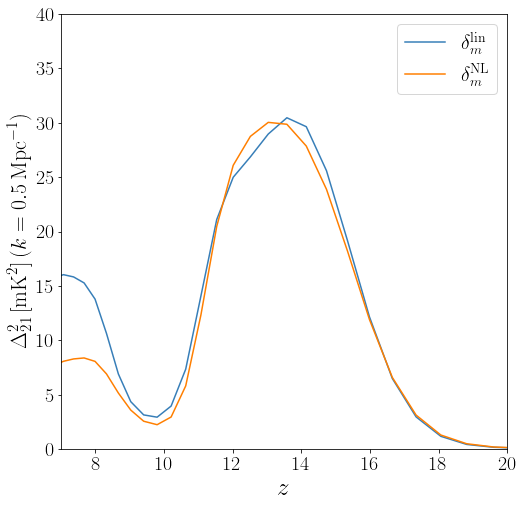

In [11]:
fig, ax = plotting.plot_1d_power_spectrum(power_spectrum_FirstCLASS,k=0.5,label='$\delta_m^\mathrm{lin}$',smooth=True)
fig, ax = plotting.plot_1d_power_spectrum(power_spectrum_NL_in_EPS,k=0.5,label='$\delta_m^\mathrm{NL}$',smooth=True,ax=ax)
ax.set_xscale('linear')
ax.set_yscale('linear')
ax.set_xlim([7,20])
ax.set_ylim([0,40]);

### Scale dependent growth factor
Often, the baryon density field is ignored such that the total matter density field is approximated as a collisionless CDM with a <b>scale-independent growth factor (SIGF)</b> $D\left(z\right)$.

By default, 21cmFirstCLASS computes scale-dependent $\delta_b$ (baryon overdensity) and $\delta_c$ (CDM overdensity). This is done by applying $\delta_i\propto\mathcal D_i(k,z)$, where $\mathcal D_i(k,z)$ is the <b>scale-dependent growth factor (SDGF)</b>, defined as
\begin{equation}
\mathcal D_i(k,z)\equiv\frac{\mathcal T_i(k,z)}{\mathcal T_i(k,z=0)}
\end{equation}

where $\mathcal T_i(k,z)$ is the density transfer function for species $i$. This mathematical trick allows 21cmFirstCLASS to compute consistently the fluctuations in the brightness temperature at the dark ages, when linear perturbation theory can still be applied. It works as long as the scales of interest are far from the horizon and the Jeans scales, which are indeed the scales we are interested in 21cm interferometry.

To have some feeling for how the baryon SDGF is different compared to the SIGF we can plot the following.
#### Note
The next code section is planned to be part of 21cmFirstCLASS in its next version.

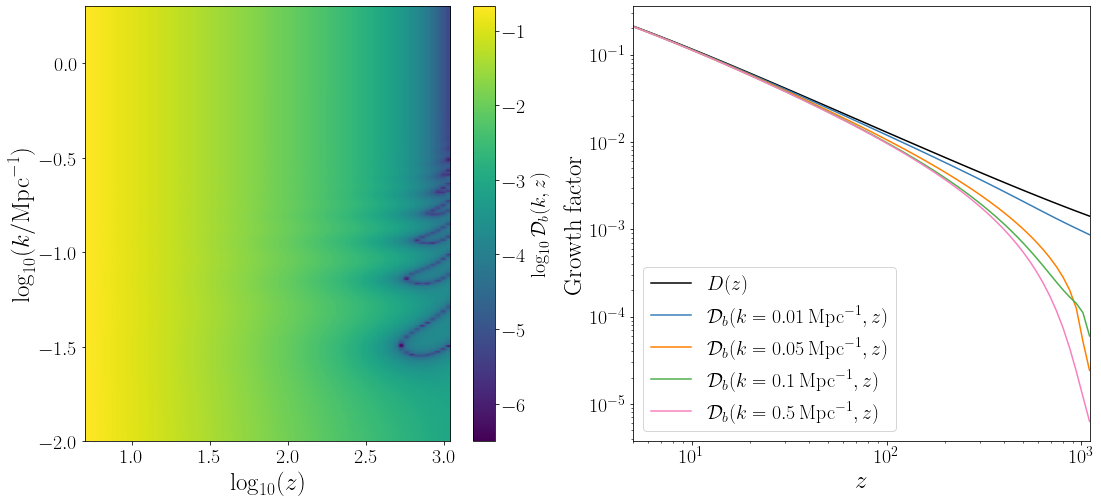

In [12]:
from scipy.interpolate import RectBivariateSpline

# Extract these quantities from global_params
k = pow(10.,np.array(global_params.LOG_K_ARR_FOR_SDGF)) # 1/Mpc
z = pow(10.,np.array(global_params.LOG_Z_ARR))
D = pow(10.,np.array(global_params.LOG_SIGF))
D_b = pow(10.,np.array(global_params.LOG_SDGF_BARYONS)).reshape(len(k),len(z))

# Take the log values
logk = np.log10(k)
logz = np.log10(z)
logD_b = np.log10(D_b)

# First plot: 2d image of SDGF
fig, ax = plt.subplots(1, 2, figsize=(18, 8))
plt.sca(ax[0])
plt.imshow(logD_b,aspect='auto',origin='lower',
           extent=(min(logz),max(logz),min(logk),max(logk)))

# Prettify the plot
cb = plt.colorbar(orientation="vertical")
cb.ax.tick_params(labelsize=20)
cb.ax.set_ylabel(r'$\log_{10}\mathcal D_b(k,z)$',fontsize=20)
ax[0].xaxis.set_tick_params(labelsize=20)
ax[0].yaxis.set_tick_params(labelsize=20)
ax[0].set_xlabel(xlabel=r'$\log_{10}(z)$',fontsize=25)
ax[0].set_ylabel(ylabel=r'$\log_{10}(k/\mathrm{Mpc}^{-1})$',fontsize=25)

# Second plot: SIGF vs. SDGF
ax[1].loglog(z,D,color='black',label=r'$D(z)$')
k_values = [0.01,0.05,0.1,0.5] # 1/Mpc
for k_value in k_values:
    D_b_k = np.exp(RectBivariateSpline(logk, logz, np.log(D_b))(np.log10(k_value),logz))[0]
    ax[1].loglog(z,D_b_k,label=r'$\mathcal D_b(k={%g}'%k_value+r'\,\mathrm{Mpc}^{-1},z)$')

# Prettify the plot
ax[1].xaxis.set_tick_params(labelsize=20)
ax[1].yaxis.set_tick_params(labelsize=20)
ax[1].set_xlabel(xlabel=r'$z$',fontsize=25)
ax[1].set_ylabel(ylabel=r'Growth factor',fontsize=25)
ax[1].set_xlim([min(z),max(z)])
ax[1].legend(fontsize=20);

Unlike the SIGF, not only that the baryon SDGF is scale dependent, it also has not trivial scale dependence close to time of recombination. This is due to the fact that at around this time the baryons do not cluster, but rather their density field oscillates along with the CMB. This is similar to the well known baryon acoustic oscillations (BAO) phenomenon.

We can plot a similar plot for the CDM SDGF. Here, the differences are much smaller and apparent at high redshifts. At low redshifts (cosmic dawn), the approximation $\mathcal D_c\left(k,z\right)\approx D\left(z\right)$ is much more successful, though we note that this approximation yields fake BAO in the CDM density field at $z\gtrsim1$ (see more details in appendix A in arXiv: 2411.00089).

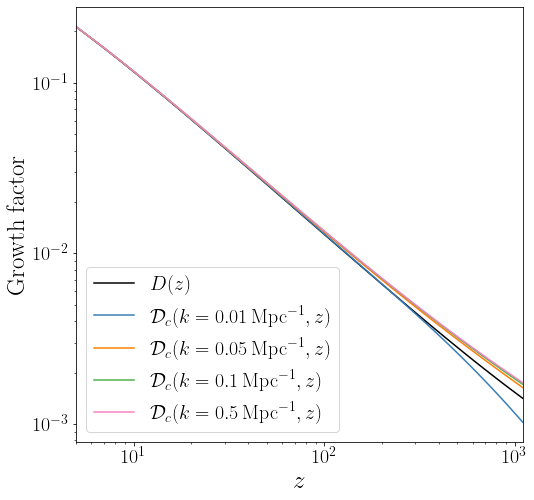

In [13]:
from scipy.interpolate import RectBivariateSpline

D_c = pow(10.,np.array(global_params.LOG_SDGF_CDM)).reshape(len(k),len(z))

# Plot: SIGF vs. SDGF (CDM)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.loglog(z,D,color='black',label=r'$D(z)$')
k_values = [0.01,0.05,0.1,0.5] # 1/Mpc
for k_value in k_values:
    D_c_k = np.exp(RectBivariateSpline(logk, logz, np.log(D_c))(np.log10(k_value),logz))[0]
    ax.loglog(z,D_c_k,label=r'$\mathcal D_c(k={%g}'%k_value+r'\,\mathrm{Mpc}^{-1},z)$')

# Prettify the plot
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
ax.set_xlabel(xlabel=r'$z$',fontsize=25)
ax.set_ylabel(ylabel=r'Growth factor',fontsize=25)
ax.set_xlim([min(z),max(z)])
ax.legend(fontsize=20);

This is why it is often approximated that $\mathcal D_m\left(k,z\right)\approx D\left(z\right)$, where the SDGF of the total matter density field is formally defined as weighted average of the baryon and CDM SDGFs,
\begin{equation}
\mathcal D_m\left(k,z\right)\equiv\frac{\Omega_b}{\Omega_m}\mathcal D_b\left(k,z\right)+\frac{\Omega_c}{\Omega_m}\mathcal D_c\left(k,z\right).
\end{equation}

## 3rd run: use the SIGF instead the SDGF (for CDM)
In order to approximate the total matter field as collisionless CDM, with $\mathcal D_m\left(k,z\right)\approx\mathcal D_c\left(k,z\right)\approx D\left(z\right)$ simply set EVOLVE_MATTER in user_params to be False. As a consequence, the matter density variance would be proportional to the square of the growth factor, $\mathcal \sigma^2\left(M,z\right)\propto D^2\left(z\right)$, allowing the code to run faster during cosmic dawn.

In addition, note we have set on True a new argument in 'run_lightcone' called 'get_c_T'. We will explain its meaning shortly.

In [14]:
user_params['EVOLVE_MATTER'] = False

lightcone_matter_is_CDM = p21c.run_lightcone(redshift = 6., # minimum redshift at which the simulation will stop
                                             random_seed = 1, # numerical seed -- if None, each run will produce different initial conditions, with the same cosmological power spectrum but different spatial realization. You need to specify the random seed to coherently compare two different runs, due to cosmic variance. 
                                             regenerate = True, # create new data even if cached are found
                                             write = False, # whether or no to save cached files
                                             user_params = user_params,
                                             astro_params = astro_params,
                                             flag_options = flag_options,
                                             cosmo_params = cosmo_params,
                                             global_quantities = global_quantities,
                                             lightcone_quantities = lightcone_quantities,
                                             get_c_T = True, k_values = [0.01,0.5]) ; # We will explain shortly what these arguments do

Now running CLASS...
Now generating initial boxes...


21cmFAST (cosmic dawn): 100%|█████████████| 84/84 [00:34<00:00,  2.46redshift/s]


Now evaluating tau to reionization and re-running CLASS...


## 4th run: use the SIGF instead the SDGF (also for baryons)
It is well known that the 21cm signal comes from hyperfine transitions in hydrogen atoms, and that hydrogen atoms are... <b>baryons</b>! <br>
Thus, perturbations in the 21cm signal are sourced from perturbations in the baryon density $\delta_b$. <b>This is especially important during the dark ages</b>, while at the time of cosmic dawn the baryons are attracted by the gravitational wells sourced by CDM clustering, and so $\delta_b\to\delta_c$.

In order to switch to the old SIGF formalism as in public 21cmFAST with $\delta_b\approx\delta_c\propto D\left(z\right)$, simply set EVOLVE_BARYONS in user_params to be False. This will make the code to run faster as we no longer need to go back and forth to\from Fourier space like we do for the SDGF. 

Note the automatic warning message that shows up in these settings.

In [15]:
user_params['EVOLVE_BARYONS'] = False

lightcone_SIGF = p21c.run_lightcone(redshift = 6., # minimum redshift at which the simulation will stop
                                    random_seed = 1, # numerical seed -- if None, each run will produce different initial conditions, with the same cosmological power spectrum but different spatial realization. You need to specify the random seed to coherently compare two different runs, due to cosmic variance. 
                                    regenerate = True, # create new data even if cached are found
                                    write = False, # whether or no to save cached files
                                    user_params = user_params,
                                    astro_params = astro_params,
                                    flag_options = flag_options,
                                    cosmo_params = cosmo_params,
                                    global_quantities = global_quantities,
                                    lightcone_quantities = lightcone_quantities,
                                    get_c_T = True) ; # We will explain shortly what that argument does

You have set EVOLVE_BARYONS to False but OUTPUT_AT_DARK_AGES is True!
Note that the 21cm power spectrum during the dark ages will be inconsistent.
Consider setting EVOLVE_BARYONS to True.



Now running CLASS...
Now generating initial boxes...


21cmFAST (cosmic dawn): 100%|█████████████| 84/84 [00:27<00:00,  3.08redshift/s]


Now evaluating tau to reionization and re-running CLASS...


Working with SDGF (for $\delta_b\neq\delta_c$) or SIGF (for $\delta_b=\delta_c$) does not change the global signal.

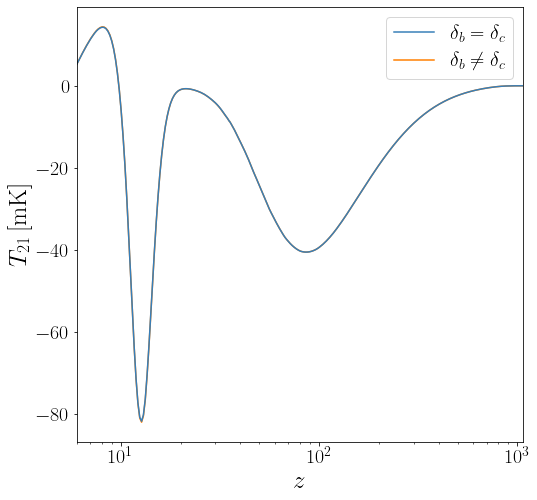

In [16]:
fig, ax = plotting.plot_global_history(lightcone_SIGF,zorder=1,label=r'$\delta_b=\delta_c$')
plotting.plot_global_history(lightcone_matter_is_CDM,ax=ax,zorder=0,label=r'$\delta_b\neq\delta_c$');

However, the 21cm power spectrum is roughly proportional to the square of the fractional fluctuation in the brightness temperature, $\Delta_{21}^2\propto\delta_{21}^2$, where $\delta_{21}\equiv T_{21}/\overline T_{21}-1$. Since during the dark ages the perturbations in the 21cm signal are sourced from $\delta_b$, we can state that $\Delta_{21}^2\propto\delta_b^2$.

Now, because $\delta_b<\delta_c$, you would expect that working with the SIGF results in overestimation of the 21cm power spectrum during the dark ages. And you would be right!

To see that, we compute the power spectrum for the two cases, first when we considered $\delta_b=\delta_c$ and then when we considered $\delta_b\neq\delta_c$.

In [17]:
power_spectrum_CDM = ps.lightcone_power_spectrum(lightcone_SIGF)
power_spectrum_baryons = ps.lightcone_power_spectrum(lightcone_matter_is_CDM)

And now we compare the two power spectra.
### Important Note!
The following power spectrum plots are imprecise, as we have set a small box with very low resolution!
In order to achieve the correct power spectrum, you must increase BOX_LEN and HII_DIM!

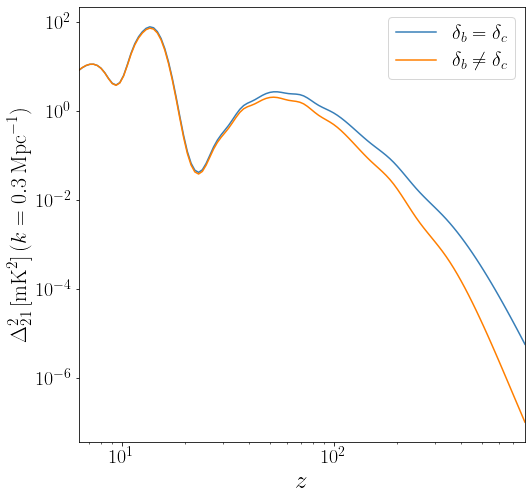

In [18]:
fig, ax = plotting.plot_1d_power_spectrum(power_spectrum_CDM,k=0.3,smooth=True,label=r'$\delta_b=\delta_c$')
fig, ax = plotting.plot_1d_power_spectrum(power_spectrum_baryons,k=0.3,smooth=True,ax=ax,label=r'$\delta_b\neq\delta_c$');

While we stress that the above power spectra are imprecise quantitively, we can still observe two qualitative features.
- First, as expected, taking $\delta_b\neq\delta_c$ results in less power during the dark ages, for redshifts as low as $z\sim20$.
- Second, there are $\mathcal O\left(10\%\right)$ differences even during cosmic dawn (see appendix D in arXiv: 2411.00089).

### Early temperature fluctuations
Because we have set get_c_T = True in the previous runs, we can now plot $c_T(k,z)$. This quantity is defined as $c_T(k,z)\equiv\delta_T(k,z)/\delta_b(k,z)$, where $\delta_T$ is the fractional fluctuation in $T_k$.

In the last simulation we have sourced all the perturbations in all the fields from $\delta_b=\delta_c$. Since under this approxiamtion $\delta_b$ grows like the SIGF $D(z)$, namely it is scale-independent, then all the perturbations in the other fields are scale-independent too, as long as we have not entered the non-linear regime of cosmic dawn. This means that by definition $c_T(k,z)$ is expected to be scale-independent during the dark ages, under the assumption of $\delta_b=\delta_c$. When EVOLVE_BARYONS = False, 21cmFirstCLASS computes $c_T(z)$ at every output redshift by computing $\delta_T$ from the $T_k$ coeval box and dividing it by the $\delta_b=\delta_c$ coeval box. This operation should yield an homogeneous (scale-independent) $c_T$ box, and we take the median of this box to remove any numerical error in the process.

If however EVOLVE_BARYONS = True, then all perturbations in 21cmFirstCLASS are scale-dependent. This means that now $c_T(k,z)$ becomes scale-dependent as well.

Since we set get_c_T = True in the two last runs, we can access the arrays that are stored in 'c_T_median' as we show below (note that similar quantities, e.g. $c_{x_e}$, $c_{T_s}$ and $c_{21}$ can be extacted from the lightcone object in a similar fashion).

In [19]:
print(f'Shape of c_T_median when SDGF is used is {lightcone_matter_is_CDM.c_T_median.shape}')
print(f'Shape of c_T_median when SIGF is used is {lightcone_SIGF.c_T_median.shape}')

Shape of c_T_median when SDGF is used is (2, 256)
Shape of c_T_median when SIGF is used is (256,)


In the first run $c_T(k,z)$ was scale-dependent, therefore lightcone.c_T_median is a 2d array. Its columns correspond to the redshift entries of lightcone.node_redshifts, while its rows correspond to the wavenumbers listed in 'k_values'. In the second run $c_T(z)$ was scale-independent, and thus lightcone.c_T_median is a 1d array, whose elements correspond to the the redshift entries of lightcone.node_redshifts.

Below we show how to plot $c_T(k,z)$ from the 21cmFirstCLASS output.

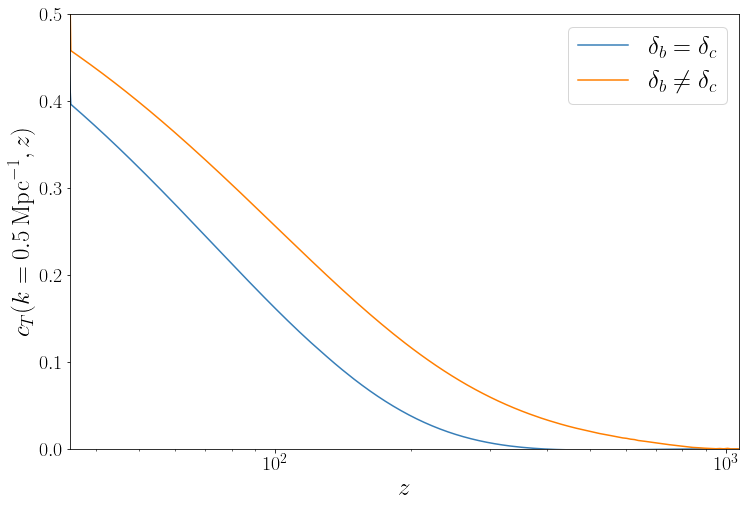

In [20]:
# Plot c_T(k,z)! 
# In the second curve we choose the 1st column in c_T_median, which is associated with k=0.5/Mpc, that was the 
# 1st entry in 'k_values'. If we had chosen the 0'th entry instead (correponds to k=0.01/Mpc, which was to the 
# 0'th entry in 'k_values'), then we would get junk because our box is not large enough, see details below.

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.semilogx(lightcone_SIGF.node_redshifts,lightcone_SIGF.c_T_median,label=r'$\delta_b=\delta_c$')
ax.semilogx(lightcone_matter_is_CDM.node_redshifts,lightcone_matter_is_CDM.c_T_median[1,:],label=r'$\delta_b\neq\delta_c$')

# Prettify the plot
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
ax.set_xlabel(xlabel='$z$',fontsize=25)
ax.set_ylabel(ylabel='$c_T(k=0.5\,\mathrm{Mpc}^{-1},z)$',fontsize=25)
# We cut the plot at Z_HEAT_MAX since afterwards non-linearities occur and there is mode mixing
ax.set_xlim([global_params.Z_HEAT_MAX,np.max(lightcone_SIGF.node_redshifts)])
ax.set_ylim([0,0.5])
ax.legend(fontsize=25) ;

#### Note
Unlike the scale-independent scenario where the $c_T$ box is almost homogeneous (up to some numerical errors), this is not the case when EVOLVE_BARYONS = True. Thus, only part of the cells can be used to compute the median of the $c_T$ box (in Fourier space). If we denote a user's wavenumber (listed in 'k_values') by $k_0$, then only the following cells of the $c_T(\mathbf k)$ box are selected for computing the median:

\begin{equation}
k_0-\Delta k/2 < \left|\mathbf k\right|< k_0+\Delta k/2
\end{equation}

where $\Delta k=2\pi$/BOX_LEN. This discretization of Fourier space results in less precise results compared to the scale-independent scenario. Rather precise results could still be obtained, but that requires working with large BOX_LEN (so $\Delta k$ is small), and large HII_DIM (in order to have more samples in Fourier space for the median). Regardless, the computation of $c_T(k,z)$ is more precise for smaller scales (larger $k$'s) due to 'cosmic variance' (there are more samples in Fourier space when $k$ is larger). In the above example, if we had plotted lightcone_matter_is_CDM.c_T_median[0,:] instead, we would get junk as our box is not large enough.

#### Another note
If we had extended the $c_T(k,z)$ plot below $z=35$ we would have seen an unsmooth transition at that redshift. This happens as in that point 21cmFirstCLASS transitions by default from linear perturbation theory to 2nd order Lagrangian perturbation theory (2LPT).

You can control the moment of transition from linear perturbation theory to 2LPT by changing the value of the following global parameter prior the run of 21cmFirstCLASS.

In [21]:
print(f'Transition redshift from linear theory to 2LPT is z={global_params.REDSHIFT_2LPT}')

Transition redshift from linear theory to 2LPT is z=35.0


## 5th run: no update of $\tau_\mathrm{reio}$
You probably have noticed that in the previous runs the following status message was printed at the end of the simulation: "Now evaluating tau to reionization and re-running CLASS..."

By default, 21cmFirstCLASS computes $\tau_\mathrm{reio}$ from the output of the 21cmFAST simulation, consistently with the other cosmological and astrophysical parameters (see details in https://arxiv.org/pdf/2305.07056). Therfore, when accessing $\tau_\mathrm{reio}$ from the lightcone object, a different value appears (we set at the begining of this notebook an input value of $\tau_\mathrm{reio}=0.0544$).

In [22]:
print(f'tau_reio = {lightcone_SIGF.cosmo_params.tau_reio}')

tau_reio = 0.05223735703175395


Since the RUN_CLASS flag is automatically set to True (see details below), in each of the previous runs, after $\tau_\mathrm{reio}$ was computed from the 21cmFAST output, CLASS ran (again). As we will see below, the updated value of $\tau_\mathrm{reio}$ can alter the CMB power spectrum.

In order to prevent the code from calculating $\tau_\mathrm{reio}$ at the end of the simulation, set EVALUATE_TAU_REIO to False.

In [23]:
user_params['EVALUATE_TAU_REIO'] = False

lightcone_no_update_tau = p21c.run_lightcone(redshift = 6., # minimum redshift at which the simulation will stop
                                             random_seed = 1, # numerical seed -- if None, each run will produce different initial conditions, with the same cosmological power spectrum but different spatial realization. You need to specify the random seed to coherently compare two different runs, due to cosmic variance. 
                                             regenerate = True, # create new data even if cached are found
                                             write = False, # whether or no to save cached files
                                             user_params = user_params,
                                             astro_params = astro_params,
                                             flag_options = flag_options,
                                             cosmo_params = cosmo_params,
                                             global_quantities = global_quantities,
                                             lightcone_quantities = lightcone_quantities)

You have set EVOLVE_BARYONS to False but OUTPUT_AT_DARK_AGES is True!
Note that the 21cm power spectrum during the dark ages will be inconsistent.
Consider setting EVOLVE_BARYONS to True.



Now running CLASS...
Now generating initial boxes...


21cmFAST (cosmic dawn): 100%|█████████████| 84/84 [00:27<00:00,  3.09redshift/s]


Now, the value of $\tau_\mathrm{reio}$ that is stored in the lightcone object is the same as our input value.

In [24]:
print(f'tau_reio = {lightcone_no_update_tau.cosmo_params.tau_reio}')

tau_reio = 0.0544


As was mentioned above, the updated (and consistent!) value of $\tau_\mathrm{reio}$ modifies the CMB power spectrum.

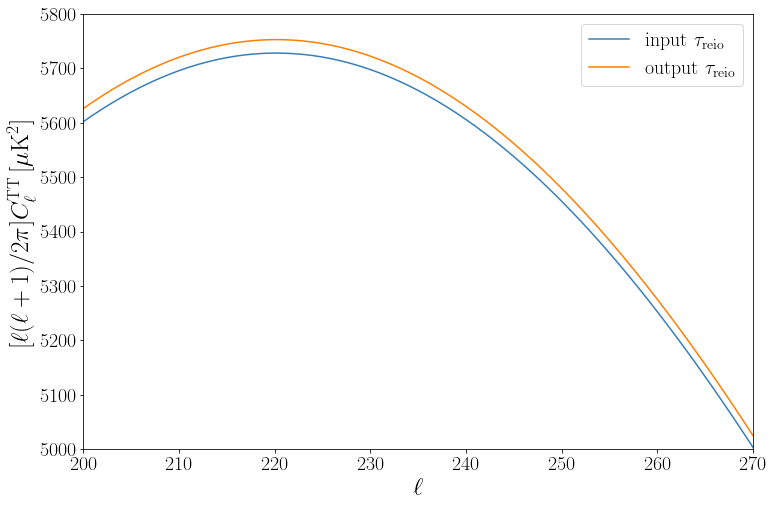

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

fig, ax =plotting.plot_Cl_data(lightcone_no_update_tau,
                               mode='TT',
                               Dl_plot=True,
                               label=r'input $\tau_\mathrm{reio}$',
                               ax=ax);

fig, ax =plotting.plot_Cl_data(lightcone_SIGF,
                               mode='TT',
                               Dl_plot=True,
                               label=r'output $\tau_\mathrm{reio}$',
                               ax=ax);

ax.set_xlim([200,270])
ax.set_ylim([5000,5800]);

## 6th run: from $z=100$
Previously we have seen that by default 21cmFirstCLASS begins at recombination, around $z\sim1000$. <br>
21cmFirstCLASS also allows you to specify the initial redshift of the simulation with the parameter Z_HIGH_MAX. In the example below, we set its value on 100.

In [26]:
user_params['Z_HIGH_MAX'] = 100.

lightcone_zmax100 = p21c.run_lightcone(redshift = 6., # minimum redshift at which the simulation will stop
                                       random_seed = 1, # numerical seed -- if None, each run will produce different initial conditions, with the same cosmological power spectrum but different spatial realization. You need to specify the random seed to coherently compare two different runs, due to cosmic variance. 
                                       regenerate = True, # create new data even if cached are found
                                       write = False, # whether or no to save cached files
                                       user_params = user_params,
                                       astro_params = astro_params,
                                       flag_options = flag_options,
                                       cosmo_params = cosmo_params,
                                       global_quantities = global_quantities,
                                       lightcone_quantities = lightcone_quantities)

You have set EVOLVE_BARYONS to False but OUTPUT_AT_DARK_AGES is True!
Note that the 21cm power spectrum during the dark ages will be inconsistent.
Consider setting EVOLVE_BARYONS to True.



Now running CLASS...
Now generating initial boxes...


21cmFAST (cosmic dawn): 100%|█████████████| 84/84 [00:27<00:00,  3.05redshift/s]


Clearly, the code spends less time during the dark ages as it has less redshift iterations in that epoch.

The logic in 21cmFirstCLASS is to begin at recombination (where $x_e$=0.1, see plots below) if Z_HIGH_MAX is negative (its default value is -1), otherwise the code begins from the initial redshift the user has specified.

Now, when we plot the global signal, we can only plot it until $z=100$.

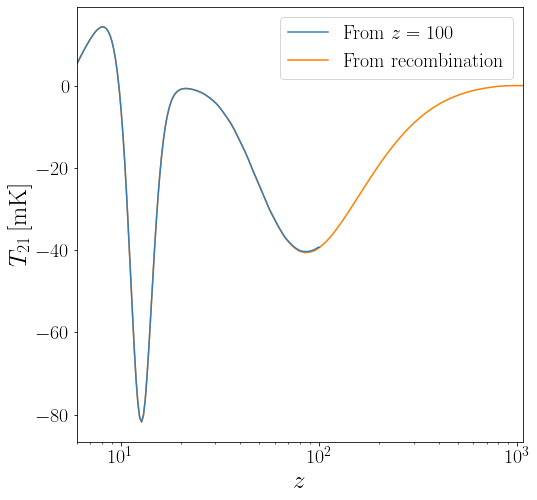

In [27]:
fig, ax = plotting.plot_global_history(lightcone_zmax100,zorder=1,label=r'From $z=100$')
plotting.plot_global_history(lightcone_no_update_tau,ax=ax,zorder=0,label=r'From recombination');

## 7th run: no output during dark ages
If you are only interested in the output during cosmic dawn, you can disable in 21cmFirstCLASS the flag called OUTPUT_AT_DARK_AGES. Note that when working in these settings, the simulation still begins at recombination, even though we get no output during the dark ages.

In [28]:
user_params['OUTPUT_AT_DARK_AGES'] = False
user_params['Z_HIGH_MAX'] = -1. # We need to set this parameter to be negative in order to start from recombination again

lightcone_no_output_at_dark_ages = p21c.run_lightcone(redshift = 6., # minimum redshift at which the simulation will stop
                                                      random_seed = 1, # numerical seed -- if None, each run will produce different initial conditions, with the same cosmological power spectrum but different spatial realization. You need to specify the random seed to coherently compare two different runs, due to cosmic variance. 
                                                      regenerate = True, # create new data even if cached are found
                                                      write = False, # whether or no to save cached files
                                                      user_params = user_params,
                                                      astro_params = astro_params,
                                                      flag_options = flag_options,
                                                      cosmo_params = cosmo_params,
                                                      global_quantities = global_quantities,
                                                      lightcone_quantities = lightcone_quantities)

Now running CLASS...
Now generating initial boxes...
Now going through the dark ages...


21cmFAST (cosmic dawn): 100%|█████████████| 84/84 [00:27<00:00,  3.04redshift/s]


Note that the simulation ended faster in these settings! (compared to previous runs where we had OUTPUT_AT_DARK_AGES = True)<br>
This is because in the above settings 21cmFirstCLASS remains at the C-code throughout the dark ages. This allows the code to run faster, in the cost of not returning any output during that epoch (this is also the reason why we don't see a dark ages progress bar in these settings).

## 8th run: no HYREC
By default, 21cmFirstCLASS uses the state-of-the-art HYREC code to evolve the free electron fraction $x_e$ as precisely as possible. In order to deactivate HYREC, simply set USE_HYREC = False. Then, the case-B recombination rate from RECFAST is used during the dark ages, while during cosmic dawn the evolution equation for $x_e$ is taken from public 21cmFAST, where a constant clumping factor of value 2 and the case-A recombination rate are used.

In [29]:
user_params['USE_HYREC'] = False
user_params['OUTPUT_AT_DARK_AGES'] = True # We set this flag on True since we want to have output at the dark ages for this scenario

lightcone_no_hyrec = p21c.run_lightcone(redshift = 6., # minimum redshift at which the simulation will stop
                                        random_seed = 1, # numerical seed -- if None, each run will produce different initial conditions, with the same cosmological power spectrum but different spatial realization. You need to specify the random seed to coherently compare two different runs, due to cosmic variance. 
                                        regenerate = True, # create new data even if cached are found
                                        write = False, # whether or no to save cached files
                                        user_params = user_params,
                                        astro_params = astro_params,
                                        flag_options = flag_options,
                                        cosmo_params = cosmo_params,
                                        global_quantities = global_quantities,
                                        lightcone_quantities = lightcone_quantities)

You have set EVOLVE_BARYONS to False but OUTPUT_AT_DARK_AGES is True!
Note that the 21cm power spectrum during the dark ages will be inconsistent.
Consider setting EVOLVE_BARYONS to True.



Now running CLASS...
Now generating initial boxes...


21cmFAST (cosmic dawn): 100%|█████████████| 84/84 [00:27<00:00,  3.08redshift/s]


## 9th run: only cosmic dawn
As we saw previously, 21cmFirstCLASS performs calculations during dark ages by default. You can disable this feature by setting the flag START_AT_RECOMBINATION on False. That way, the simulation begins from the global parameter Z_HEAT_MAX (default is $z=35$), as in the public 21cmFAST.

Note that if OUTPUT_AT_DARK_AGES = True but START_AT_RECOMBINATION = False, an automatic logic changes the value of START_AT_RECOMBINATION to be True. This is why we also set OUTPUT_AT_DARK_AGES = False.

In [30]:
user_params['START_AT_RECOMBINATION'] = False
user_params['OUTPUT_AT_DARK_AGES'] = False # We must also set this flag to False in order to prevent an automatic logic to change the above flag to True

lightcone_only_cosmic_dawn = p21c.run_lightcone(redshift = 6., # minimum redshift at which the simulation will stop
                                                random_seed = 1, # numerical seed -- if None, each run will produce different initial conditions, with the same cosmological power spectrum but different spatial realization. You need to specify the random seed to coherently compare two different runs, due to cosmic variance. 
                                                regenerate = True, # create new data even if cached are found
                                                write = False, # whether or no to save cached files
                                                user_params = user_params,
                                                astro_params = astro_params,
                                                flag_options = flag_options,
                                                cosmo_params = cosmo_params,
                                                global_quantities = global_quantities,
                                                lightcone_quantities = lightcone_quantities)

Now running CLASS...
Now generating initial boxes...


21cmFAST (cosmic dawn): 100%|█████████████| 84/84 [00:26<00:00,  3.17redshift/s]


### The effect of HYREC on the global 21cm signal during cosmic dawn

During cosmic dawn, the 21cm global signal is the same whether we start the simulation from $z=35$ or from recombination, as long as for the latter we activate HYREC.

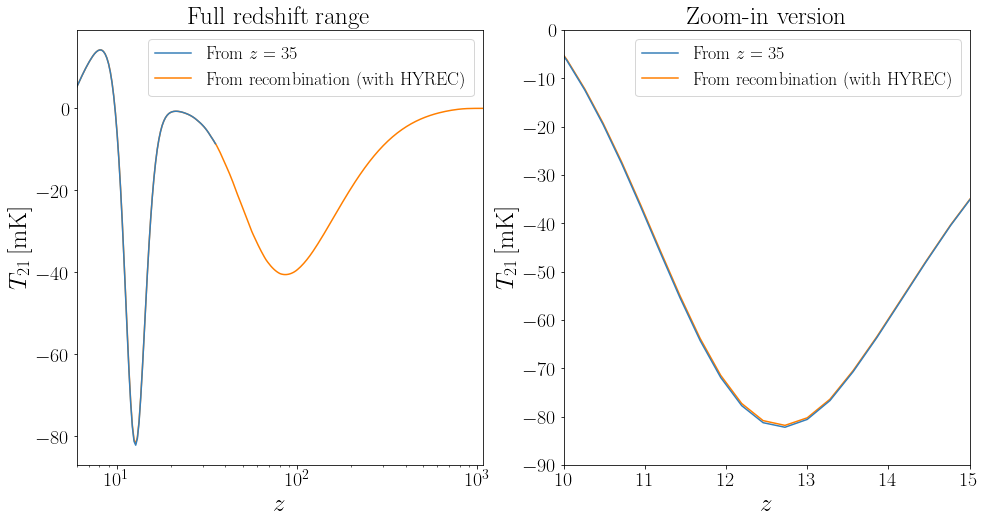

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# Plot full redshift range
plotting.plot_global_history(lightcone_only_cosmic_dawn,ax=ax[0],zorder=1,label='From $z=35$')
plotting.plot_global_history(lightcone_no_update_tau,ax=ax[0],zorder=0,label='From recombination (with HYREC)')
ax[0].set_title('Full redshift range',fontsize=25)
ax[0].legend(loc='upper right',fontsize=18)

# Zoom-in version
plotting.plot_global_history(lightcone_only_cosmic_dawn,ax=ax[1],zorder=1,label='From $z=35$')
plotting.plot_global_history(lightcone_no_update_tau,ax=ax[1],zorder=0,label='From recombination (with HYREC)',xlog=False)
ax[1].set_xlim([10,15])
ax[1].set_ylim([-90,0])
ax[1].set_title('Zoom-in version',fontsize=25)
ax[1].legend(loc='upper right',fontsize=18);

The relative error is at the sub-percent level.

In [32]:
error = 100.*np.abs(np.min(lightcone_no_update_tau.global_brightness_temp)/np.min(lightcone_only_cosmic_dawn.global_brightness_temp)-1.)
print(f'Error at the minimum is {error:.3}%')

Error at the minimum is 0.47%


However, when disabling HYREC and starting the simulation from recombination, inconsistencies during cosmic dawn occur.

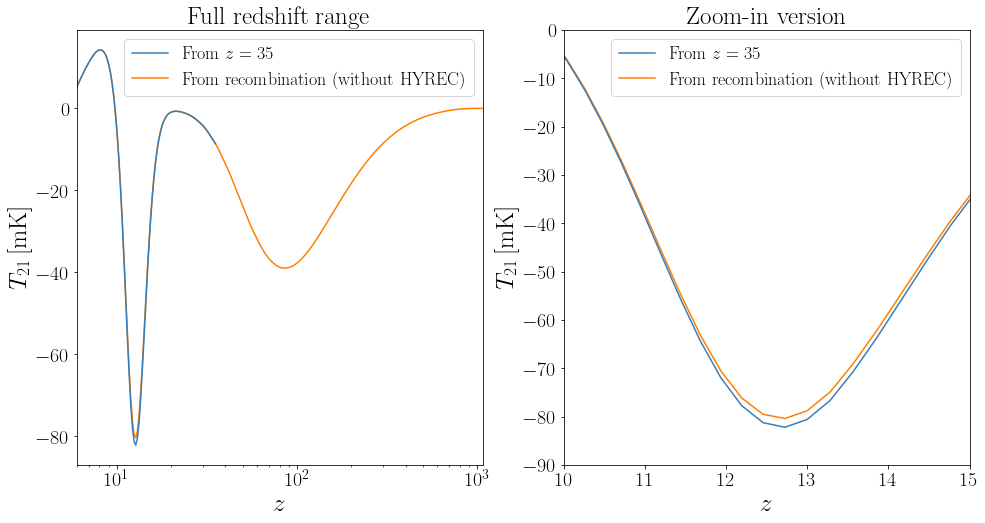

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# Plot full redshift range
plotting.plot_global_history(lightcone_only_cosmic_dawn,ax=ax[0],zorder=1,label='From $z=35$')
plotting.plot_global_history(lightcone_no_hyrec,ax=ax[0],zorder=0,label='From recombination (without HYREC)')
ax[0].set_title('Full redshift range',fontsize=25)
ax[0].legend(loc='upper right',fontsize=18)

# Zoom-in version
plotting.plot_global_history(lightcone_only_cosmic_dawn,ax=ax[1],zorder=1,label='From $z=35$')
plotting.plot_global_history(lightcone_no_hyrec,ax=ax[1],zorder=0,label='From recombination (without HYREC)',xlog=False)
ax[1].set_xlim([10,15])
ax[1].set_ylim([-90,0])
ax[1].set_title('Zoom-in version',fontsize=25)
ax[1].legend(loc='upper right',fontsize=18);

Here, the relative error at the minimum exceeds the percent level.

In [34]:
error = 100.*np.abs(np.min(lightcone_no_hyrec.global_brightness_temp)/np.min(lightcone_only_cosmic_dawn.global_brightness_temp)-1.)
print(f'Error at the minimum is {error:.3}%')

Error at the minimum is 2.2%


What is the source of this error?

To understand that, let us plot $x_e$ in the last two scenarios we compared.

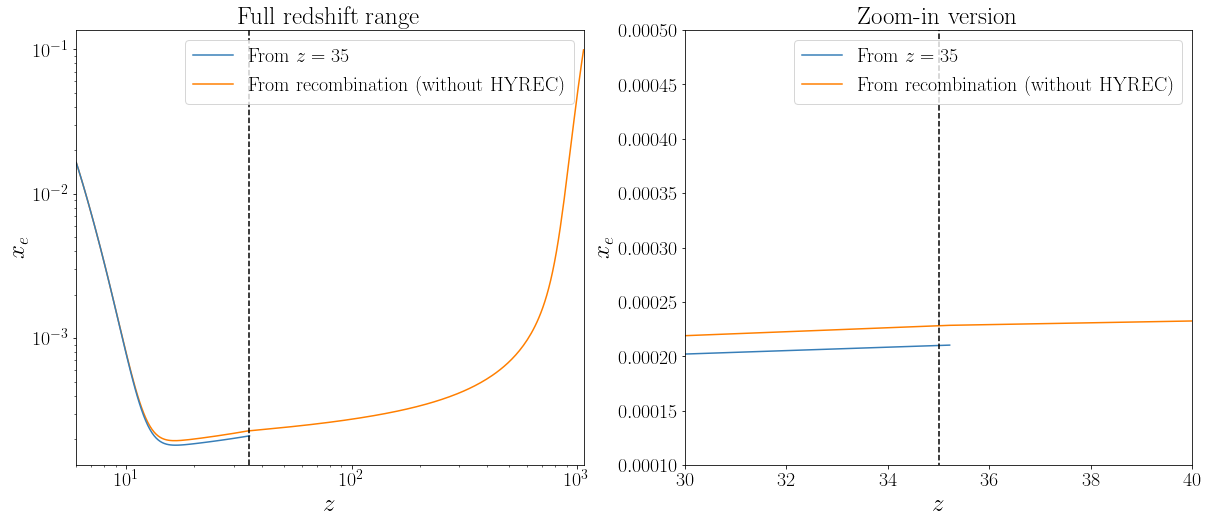

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# Plot full redshift range
plotting.plot_global_history(lightcone_only_cosmic_dawn,kind='x_e_box',ax=ax[0],zorder=1,label='From $z=35$')
plotting.plot_global_history(lightcone_no_hyrec,kind='x_e_box',ax=ax[0],zorder=0,label='From recombination (without HYREC)')
ax[0].set_title('Full redshift range',fontsize=25)
ylim = ax[0].get_ylim()
ax[0].plot([global_params.Z_HEAT_MAX,global_params.Z_HEAT_MAX],ylim,color='black',ls='--')
ax[0].set_ylim(ylim);

# Zoom-in version
plotting.plot_global_history(lightcone_only_cosmic_dawn,kind='x_e_box',ax=ax[1],zorder=1,label='From $z=35$',ylog=False)
plotting.plot_global_history(lightcone_no_hyrec,kind='x_e_box',ax=ax[1],zorder=0,label='From recombination (without HYREC)',ylog=False,xlog=False)
ax[1].set_title('Zoom-in version',fontsize=25)
ax[1].plot([global_params.Z_HEAT_MAX,global_params.Z_HEAT_MAX],[0,1],color='black',ls='--')
ax[1].set_xlim([30,40])
ax[1].set_ylim([1e-4,5e-4]);

We see that at the onset of cosmic dawn, at $z=35$, there is an inconsistency! That is, the orange curve misses by a few percent the initial value of the blue curve.

In the orange curve, we have calculated the recombination rate $\alpha(T)$ during the dark ages from the RECFAST prescription for the case-B recobmination. Below $z=35$, in both curves we have transitioned to computing the recombination rate from the case-A recombination that is found in 21cmFAST. This explains the unsmooth transition at $z=35$ of the orange curve.

Yet, the inconsistencies in the brightness temperature we saw above have nothing to do with the value of $x_e$ at $z=35$. As a matter of fact, the 21cm signal is fairly insensitive to the value of $x_e$ during cosmic dawn. However, it is sensitive to the value of $x_e$ during the dark ages, at the time of recombination. So our claim is that if we could have extended the (correct) blue curve to the time of recombination, we would see deviations and these deviations cause the discrepancy during cosmic dawn, at $z\sim13$.

To support this claim, consider the gas kinetic temperature $T_k$. Shortly after recombination, $T_k$ is still strongly coupled to the CMB temperature $T_\gamma$ via efficient Compton scattering between CMB photons and the remaining charged particles. The strength of this coupling is proportional to $x_e$. Thus, errors in $x_e$ at the time of recombination yield errors in $T_k$ at that time. Since $T_k$ is found by solving a differential equation, small errors in its initial values are then propagated to larger errors at later times.

Now, let us assume for simplicity that at $z\sim13$ the spin temperature $T_s$ completely follows $T_k$. Thus the brightness temperature is

\begin{equation}
T_{21}\propto\left(1-\frac{T_\gamma}{T_s}\right)\approx\left(1-\frac{T_\gamma}{T_k}\right)
\end{equation}

Therefore, a fractional error of $\epsilon$ in $T_k$ is converted to an absolute error in the brightness temperature of

\begin{equation}
T_{21}^\epsilon-T_{21}\propto\left(1-\frac{T_\gamma}{T_k\left(1+\epsilon\right)}\right)-\left(1-\frac{T_\gamma}{T_k}\right)\approx\frac{T_\gamma}{T_k}\epsilon
\end{equation}

This error is largest when the ratio of $T_\gamma/T_k$ is maximum, which is at the ballpark of $z\sim13$ in our simulation.

Thus, in conclusion, in order to avoid the numerical error at $z\sim13$ we must evolve $x_e$ precisely from the time of recombination. This is exactly what HYREC does, and as we saw above the said inconsistency vanishes when HYREC is turned on.

Now, if we remake the last plot, but this time when HYREC is turned on during recombination, we get consistency in $x_e$ at $z=35$.

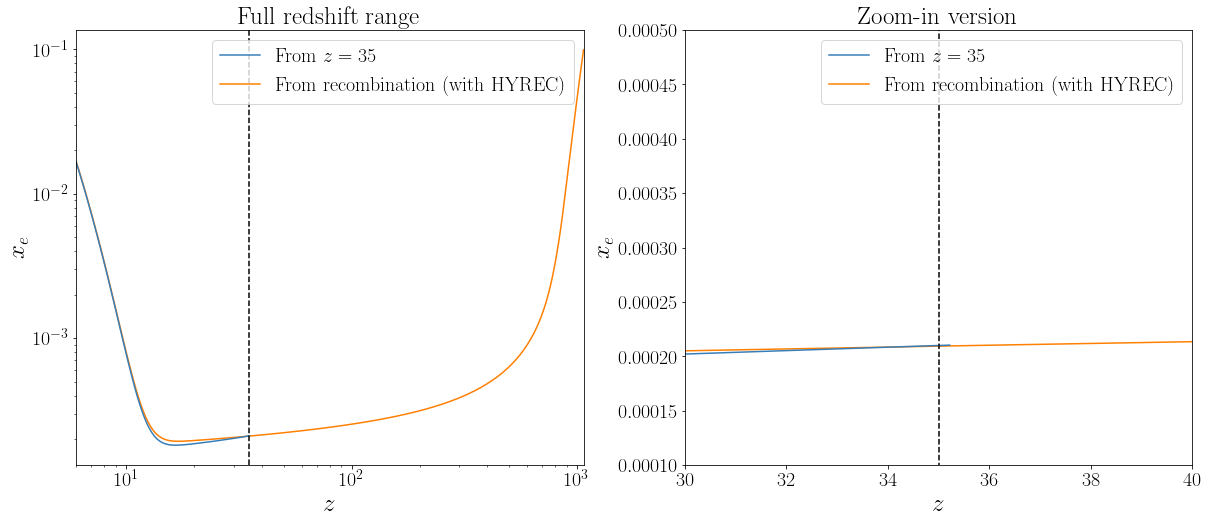

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# Plot full redshift range
plotting.plot_global_history(lightcone_only_cosmic_dawn,kind='x_e_box',ax=ax[0],zorder=1,label='From $z=35$')
plotting.plot_global_history(lightcone_no_update_tau,kind='x_e_box',ax=ax[0],zorder=0,label='From recombination (with HYREC)')
ax[0].set_title('Full redshift range',fontsize=25)
ylim = ax[0].get_ylim()
ax[0].plot([global_params.Z_HEAT_MAX,global_params.Z_HEAT_MAX],ylim,color='black',ls='--')
ax[0].set_ylim(ylim);

# Zoom-in version
plotting.plot_global_history(lightcone_only_cosmic_dawn,kind='x_e_box',ax=ax[1],zorder=1,label='From $z=35$',ylog=False)
plotting.plot_global_history(lightcone_no_update_tau,kind='x_e_box',ax=ax[1],zorder=0,label='From recombination (with HYREC)',ylog=False,xlog=False)
ax[1].set_title('Zoom-in version',fontsize=25)
ax[1].plot([global_params.Z_HEAT_MAX,global_params.Z_HEAT_MAX],[0,1],color='black',ls='--')
ax[1].set_xlim([30,40])
ax[1].set_ylim([1e-4,5e-4]);

The reason why the two curves deviate below $z=35$ is because when setting USE_HYREC on True, 21cmFirstCLASS uses HYREC to evolve $x_e$ during both cosmic dawn and the dark ages, resulting in a smooth orange curve. As for the blue curve, since HYREC is set to False, the evolution equation for $x_e$ is taken from public 21cmFAST (where a constant clumping factor of value 2 and the case-A recombination rate are used).

### The effect of early temperature fluctuations on the 21cm power spectrum during cosmic dawn
In the previous discussion we leaned that as long as HYREC is turned on during the dark ages, the global 21cm signal remains the same during cosmic dawn, regardless if the simulation begins from $z=35$ or from recombination. This statement however is incorrect when the 21cm power spectrum is considered!

To see that, we compute the power spectrum for three different scenarios:
 - when we started the simulation from recombination.
 - when we started the simulation from $z=100$.
 - when we started the simulation from $z=35$.

In [37]:
power_spectrum_recombination = ps.lightcone_power_spectrum(lightcone_no_output_at_dark_ages)
power_spectrum_100 = ps.lightcone_power_spectrum(lightcone_zmax100)
power_spectrum_35 = ps.lightcone_power_spectrum(lightcone_only_cosmic_dawn)

Now that we have computed the power spectra we can compare them.
### Important Note!
The following power spectrum plots are imprecise, as we have set a small box with very low resolution!
In order to achieve the correct power spectrum, you must increase BOX_LEN and HII_DIM!

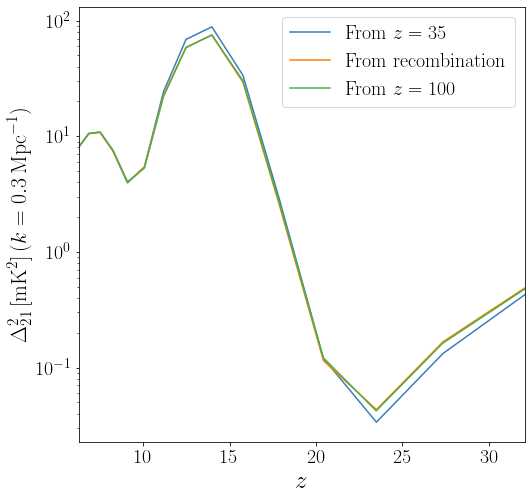

In [38]:
# Plot! (here we do not smooth the curves)
fig, ax = plotting.plot_1d_power_spectrum(power_spectrum_35,k=0.3,label='From $z=35$')
fig, ax = plotting.plot_1d_power_spectrum(power_spectrum_recombination,k=0.3,ax=ax,label='From recombination')
xlim = ax.get_xlim()
fig, ax = plotting.plot_1d_power_spectrum(power_spectrum_100,k=0.3,ax=ax,label='From $z=100$')
ax.set_xscale('linear');
ax.set_xlim(xlim);

How come the global signal is the same in all scenarios but the power spectrum is different for the blue curve (From $z=35$)?

This is the result of early temperature fluctuations during the dark ages that affect the orange curve during cosmic dawn. <br>
In the blue curve, the code begins from $z=35$ with <b>homogeneous</b> $T_k$ box. In the orange curve, the code begins from recombination with <b>homogeneous</b> $T_k$ box, but as it reaches $z=35$ this box is now <b>inhomogeneous</b> due to perturbations in the CDM density field ($\delta_c$). <br>
In other words, had $c_T(z=35)$ zero, we would end up with the same power spectrum. Since $c_T(z=35)\approx0.4$, we get different power spectra!<br>
Note that from the overlap between the green and the orange curves we can learn that it is more reasonable to assume a homogeneous $T_k$ box at $z=100$ rather at $z=35$ (though from the $c_T(z)$ plot we see that temperature fluctuations already exist above $z=100$).

## 10th run: with Dicke growth factor

By default, when EVOLVE_BARYONS = False, 21cmFirstCLASS works with SIGF $D(z)$ as derived from the output of CLASS. This growth factor solves the following differential equation (dot represents time derivative)

\begin{equation}
\ddot D +2H\dot D - 4\pi G\bar\rho_m D = 0
\end{equation}

with zero initial conditions.

In contrast, public 21cmFAST uses the "Dicke" growth factor, as defined by the fitting function below.

In [39]:
def dicke(z,Omega_m=cosmo_params['OMm']):
    Omega_z = Omega_m*(1.+z)**3/(Omega_m*(1.+z)**3 + (1.-Omega_m)) # Here we assume for simplicity that Omega_Lambda = 1 - Omega_m
    g_Omega_m = 5./2. * Omega_m*pow(1./70. + 209.*Omega_m/140. - Omega_m**2/140. + pow(Omega_m,4./7.),-1.)
    g_Omega_z = 5./2. * Omega_z*pow(1./70. + 209.*Omega_z/140. - Omega_z**2/140. + pow(Omega_z,4./7.),-1.)
    D = 1./(1.+z)*g_Omega_z/g_Omega_m
    return D

While the "Dicke" growth factor is inadequate during the dark ages, it yields sub-percent error during cosmic dawn.

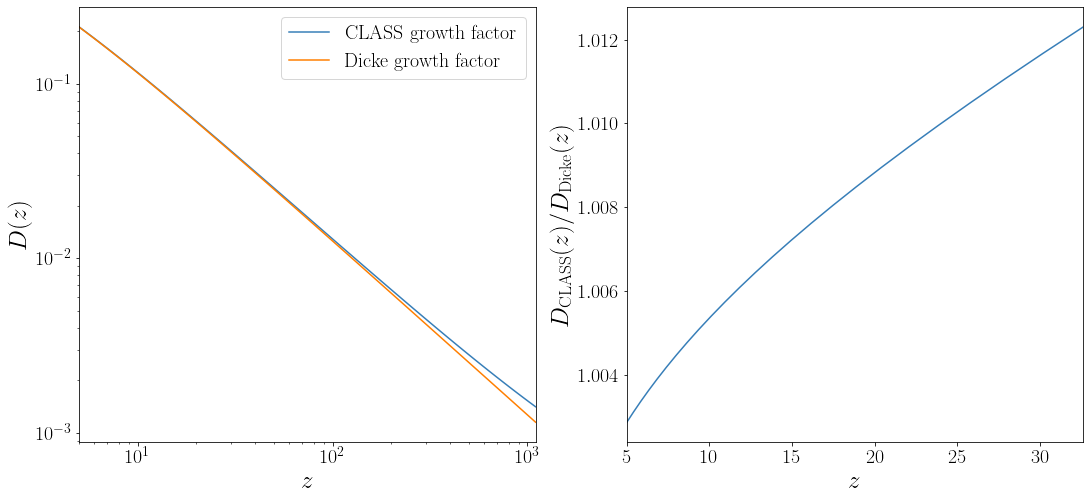

In [40]:
# Extract arrays from global_params
z = pow(10.,np.array(global_params.LOG_Z_ARR))
D_CLASS = pow(10.,np.array(global_params.LOG_SIGF))
# Calculate the Dicke growth factor
D_dicke = np.array([dicke(zz) for zz in z])

# Plot!
fig, ax = plt.subplots(1, 2, figsize=(18, 8))
ax[0].loglog(z,D_CLASS,label='CLASS growth factor')
ax[0].loglog(z,D_dicke,label='Dicke growth factor')
ax[1].plot(z[z<=global_params.Z_HEAT_MAX],(D_CLASS/D_dicke)[z<=global_params.Z_HEAT_MAX])

# Prettify the plot
ax[0].xaxis.set_tick_params(labelsize=20)
ax[0].yaxis.set_tick_params(labelsize=20)
ax[0].set_xlabel(xlabel=r'$z$',fontsize=25)
ax[0].set_ylabel(ylabel=r'$D(z)$',fontsize=25)
ax[0].set_xlim([min(z),max(z)])
ax[0].legend(fontsize=20)

# Prettify the plot
ax[1].xaxis.set_tick_params(labelsize=20)
ax[1].yaxis.set_tick_params(labelsize=20)
ax[1].set_xlabel(xlabel=r'$z$',fontsize=25)
ax[1].set_ylabel(ylabel=r'$D_\mathrm{CLASS}(z)/D_\mathrm{Dicke}(z)$',fontsize=25)
ax[1].set_xlim([min(z),max(z[z<=global_params.Z_HEAT_MAX])]);

You can run 21cmFirstCLASS with the "Dicke" growth factor (even if RUN_CLASS is True, see below) by setting USE_DICKE_GROWTH_FACTOR = True.

In [41]:
user_params['USE_DICKE_GROWTH_FACTOR'] = True

lightcone_dicke_growth_factor = p21c.run_lightcone(redshift = 6., # minimum redshift at which the simulation will stop
                                                   random_seed = 1, # numerical seed -- if None, each run will produce different initial conditions, with the same cosmological power spectrum but different spatial realization. You need to specify the random seed to coherently compare two different runs, due to cosmic variance. 
                                                   regenerate = True, # create new data even if cached are found
                                                   write = False, # whether or no to save cached files
                                                   user_params = user_params,
                                                   astro_params = astro_params,
                                                   flag_options = flag_options,
                                                   cosmo_params = cosmo_params,
                                                   global_quantities = global_quantities,
                                                   lightcone_quantities = lightcone_quantities)

Now running CLASS...
Now generating initial boxes...


21cmFAST (cosmic dawn): 100%|█████████████| 84/84 [00:26<00:00,  3.18redshift/s]


It is interesting that the choice of SIGF can shift the 21cm global signal, even though the SIGF only controls the amplitude of the fluctuations in the signal.

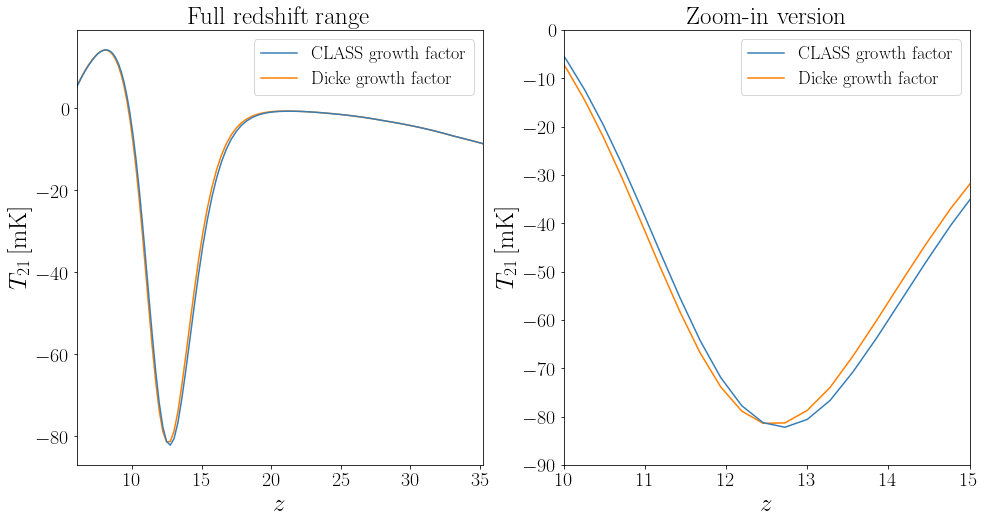

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# Plot full redshift range
plotting.plot_global_history(lightcone_only_cosmic_dawn,ax=ax[0],zorder=1,label='CLASS growth factor')
plotting.plot_global_history(lightcone_dicke_growth_factor,ax=ax[0],zorder=0,label='Dicke growth factor');
ax[0].set_title('Full redshift range',fontsize=25)
ax[0].legend(loc='upper right',fontsize=18)

# Zoom-in version
plotting.plot_global_history(lightcone_only_cosmic_dawn,ax=ax[1],zorder=1,label='CLASS growth factor')
plotting.plot_global_history(lightcone_dicke_growth_factor,ax=ax[1],zorder=0,label='Dicke growth factor');
ax[1].set_xlim([10,15])
ax[1].set_ylim([-90,0])
ax[1].set_title('Zoom-in version',fontsize=25)
ax[1].legend(loc='upper right',fontsize=18);

Why does this small shift towards lower redshifts occur when we switch to the "Dicke" growth factor?

This is due to the non-linear nature of the signal during cosmic dawn; at that epoch, $\delta_c$ could be a lot greater than 1, and so the sub-percent errors in the "Dicke" growth factor do not cancel when the mean of the box is computed. In fact, these errors are enhanced when the brightness temperature is considered due to the significant non-linearities in that quantity. Since we saw that the "Dicke" growth factor underestimates CLASS growth factor, this can be viewed as if structure formation is impeded when the former is used, hence we see that the orange curve is shifted to the left relative to the blue curve. Because the "Dicke" growth factor fits better the solution of CLASS at lower redshifts, the differences in the signals become less evident below $z\sim10$.

## 11th run: no CLASS
In all previous runs, the code ran CLASS prior the simulation of 21cmFAST. 

CLASS is used to produce the transfer functions and growth factor for the different matter components, as well as the initial background values for $x_e$ and $T_k$. All these quantities are <b>consistent</b> with the cosmological parameters the user has specified.

Once these ingredients are set, the simulation evolves using the same logic as in public 21cmFAST.

#### Note
It takes "a while” for CLASS to run, about 1 minute, depending on the version and settings of the user’s CLASS. This is because 21cmFirstCLASS runs CLASS up to $k\sim1000\,\mathrm{Mpc}^{-1}$ in order to compute $\sigma(M)$ precisely at small scales.

By default, 21cmFirstCLASS adopts derived cosmological parameters from the output of CLASS. For example, the following derived cosmological paraemeters are (slightly) different than the default values found in the Globals.h module.

In [43]:
print(f'Helium fraction is Y_He = {global_params.Y_He}')
print(f'Average relative velocity between baryons and CDM at the time of recombination is V_AVG = {global_params.VAVG} km/sec')

Helium fraction is Y_He = 0.2453682632833779
Average relative velocity between baryons and CDM at the time of recombination is V_AVG = 27.087393263505074 km/sec


You can disable CLASS in 21cmFirstCLASS by setting RUN_CLASS on False.

In [44]:
user_params['RUN_CLASS'] = False

lightcone_no_CLASS = p21c.run_lightcone(redshift = 6., # minimum redshift at which the simulation will stop
                                        random_seed = 1, # numerical seed -- if None, each run will produce different initial conditions, with the same cosmological power spectrum but different spatial realization. You need to specify the random seed to coherently compare two different runs, due to cosmic variance. 
                                        regenerate = True, # create new data even if cached are found
                                        write = False, # whether or no to save cached files
                                        user_params = user_params,
                                        astro_params = astro_params,
                                        flag_options = flag_options,
                                        cosmo_params = cosmo_params,
                                        global_quantities = global_quantities,
                                        lightcone_quantities = lightcone_quantities)

Now generating initial boxes...


21cmFAST (cosmic dawn): 100%|█████████████| 84/84 [00:26<00:00,  3.18redshift/s]


Now, when printing the derived cosmological parameters, the defaults from Globals.h are shown.

In [45]:
print(f'Helium fraction is Y_He = {global_params.Y_He}')
print(f'Average relative velocity between baryons and CDM at the time of recombination is V_AVG = {global_params.VAVG} km/sec')

Helium fraction is Y_He = 0.245
Average relative velocity between baryons and CDM at the time of recombination is V_AVG = 25.86 km/sec


#### Note
Comparing the brightness temperature between the two last runs (between RUN_CLASS = True and RUN_CLASS = False) would yield the same signal. This is because the default transfer functions in 21cmFirstCLASS correspond to Planck 2018 cosmological parameters, i.e. the same cosmological parameters we have been using in this notebook. 

However, it is important to understand that for any other set of cosmological parameters, the signal would look differently if RUN_CLASS is True or False. When RUN_CLASS is False the <b>default</b> transfer function tables are used and <b>they are not necessarily consistent</b> with the chosen set of cosmological parameters. <b>This is especially important for beyond &Lambda;CDM models</b> - see more about them in Notebook #3!

#### Another note
To remain compatible with 21cmFAST as much as possible, the logic in 21cmFirstCLASS is to have an inhomogeneous $T_k$ box at $z=35$ in case where RUN_CLASS = False and START_AT_RECOMBINATION = False. This is achieved by using the fit for $c_T(z)$ from JBM23 paper (see https://arxiv.org/pdf/2302.08506.pdf).

## 12th and final run: $\sigma_8$ (instead $A_s$)
When we set the cosmological parameters for the simulations (in the definition of the dictionary 'cosmo_params'), we have specified the amplitude of primordial curvature perturbations $A_s$. Public 21cmFAST though does not have such a parameter, and instead the user can set the value of $\sigma_8$, that is the the rms of the smoothed density field with a top-hat filter of radius $8\,\mathrm{Mpc}/h$).

When specifying $A_s$ in 21cmFirstCLASS rather than $\sigma_8$, the code automatically does the conversion (based on the values of the other cosmological parameters)

In [46]:
print(f'Value of SIGMA_8: {lightcone_no_CLASS.cosmo_params.SIGMA_8}')

Value of SIGMA_8: 0.8121428929213018


We can also work in 21cmFirstCLASS with the standard settings of 21cmFAST, by specifying $\sigma_8$ instead of $A_s$ (we cannot specify both of them!). Also, note that $A_s$ must be specified when fuzzy dark matter is simulated (more on that, in Notebook #3!).

In [47]:
cosmo_params.pop('A_s') # pop A_s out of the cosmo_params dictionary
cosmo_params['SIGMA_8'] = 0.812 # insert an entry for SIGMA_8

lightcone_FAST = p21c.run_lightcone(redshift = 6., # minimum redshift at which the simulation will stop
                                    random_seed = 1, # numerical seed -- if None, each run will produce different initial conditions, with the same cosmological power spectrum but different spatial realization. You need to specify the random seed to coherently compare two different runs, due to cosmic variance. 
                                    regenerate = True, # create new data even if cached are found
                                    write = False, # whether or no to save cached files 
                                    user_params = user_params,
                                    astro_params = astro_params,
                                    flag_options = flag_options,
                                    cosmo_params = cosmo_params,
                                    global_quantities = global_quantities,
                                    lightcone_quantities = lightcone_quantities)

Now generating initial boxes...


21cmFAST (cosmic dawn): 100%|█████████████| 84/84 [00:26<00:00,  3.17redshift/s]


Now, the value of $\sigma_8$ completely matches our input.

In [48]:
print(f'Value of SIGMA_8: {lightcone_FAST.cosmo_params.SIGMA_8}')

Value of SIGMA_8: 0.812


<b>It should be noted that the settings of the last simulation almost<sup>*</sup> match the settings of public 21cmFAST! (version 3.1.3)</b>

*&nbsp;There are two differences in the last settings and the ones found in 21cmFAST:
1. As was discussed in the beginning of this tutorial, default values of some flags are different in 21cmFirstCLASS.
2. The default transfer functions correspond to Planck 2018 cosmological parameters.

## Summary
In this notebook you have learned how to turn off the new features in 21cmFirstCLASS to restore the settings of 21cmFAST and what is their physical meaning. Below we recap these features: 
- It is possible to use the linear matter density field $\delta_m^\mathrm{lin}$ in the EPS, rather the non-linear one $\delta_m^\mathrm{NL}$ by setting <b>LINEAR_DELTA_IN_EPS</b> on True. This is only becomes possible when EVOLVE_BARYONS is set to True.
- The usual SIGF approximation for the total matter field ($\mathcal D_m\left(k,z\right)\approx D\left(z\right)$) can be applied by setting <b>EVOLVE_MATTER</b> on False. This will also approximate $\sigma^2\left(M,z\right)\propto D^2\left(z\right)$.
- In order to simulate precisely the 21cm power spectrum during the dark ages, <b>EVOLVE_BARYONS</b> must be turned on so that the baryons overdensity $\delta_b$ is considered (rather than the CDM overdensity $\delta_c$).
- You can compute $\tau_\mathrm{reio}$ from the 21cmFAST simulation if <b>EVALUATE_TAU_REIO</b> is turned on. If RUN_CLASS is also turned on, the CMB power spectrum is re-evaluated with the updated value of $\tau_\mathrm{reio}$.
- The simulation doesn't necessarily have to begin from recombination (where $x_e=0.1$). You can control the initial redshift for the simulation, when the $T_k$ box is homogeneous, by specifying a non-negative <b>Z_HIGH_MAX</b> value.
- In order to have any output during the dark ages, <b>OUTPUT_AT_DARK_AGES</b> has to be True.
- To get a consistent signal during cosmic dawn when the simulation begins at the dark ages, HYREC has to be activated with <b>USE_HYREC</b>.
- The simulation can begin prior to cosmic dawn (whether we want or not having any output during the dark ages) when <b>START_AT_RECOMBINATION</b> is True. If OUTPUT_AT_DARK_AGES = False, this causes the simulation to run faster. It is also important to begin the simulation prior to cosmic dawn for consistent evaluation of the 21cm power spectrum during that epoch.
- By default, the scale-independent growth factor from CLASS is used rather than the "Dicke" growth factor. To disable this feature, set <b>USE_DICKE_GROWTH_FACTOR</b> on True.
- <b>RUN_CLASS</b> allows you to run CLASS before the 21cmFAST simulation to generate initial conditions that are consistent with the chosen set of cosmological parameters. In addition, the CMB power spectrum is computed, allowing one to perform a joint analysis of 21cm and CMB.
- You can set the value of $A_s$ in 21cmFirstCLASS by assigning a value to the key <b>'A_s'</b> in 'cosmo_params' (rather than specifying 'SIGMA_8').

The default settings in 21cmFirstCLASS is to have all these new features automatically turned on. By disabling all of them, the settings of public 21cmFAST are restored.

## Great, you reached the end of Notebook #2!

If you want to learn more about 21cmFirstCLASS and its application, you can continue with...

- Notebook #3 , to study beyond &Lambda;CDM cosmology

- Notebook #4 , to study the detectability of the 21cm power spectrum with upcoming experiments


#### If you have questions or you find bugs, feel free to email us!
jordanf@post.bgu.ac.il

libanore@bgu.ac.il